In [ ]:
!pip install -q    torch torchvision lightning faiss-cpu boto3 supabase transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 50.0 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
import boto3
from botocore.client import Config
from supabase import create_client, Client
import torch
import torch.nn as nn
import requests
from io import BytesIO
from PIL import Image
import asyncio
import nest_asyncio
import re
# Tải các lớp và hàm cần thiết
import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer
from torchvision import transforms as T
import numpy as np
import faiss
from transformers import AutoTokenizer, AutoModel, AutoImageProcessor
import torch.nn.functional as F
import math


# Lấy API Keys và kết nối R2/Supabase (Giữ nguyên)
try:
    SUPABASE_URL = userdata.get('SUPABASE_URL')
    SUPABASE_SERVICE_KEY = userdata.get('SUPABASE_SERVICE_KEY')
    R2_ACCESS_KEY_ID = userdata.get('R2_ACCESS_KEY_ID')
    R2_SECRET_ACCESS_KEY = userdata.get('R2_SECRET_ACCESS_KEY')
    R2_ACCOUNT_ID = userdata.get('R2_ACCOUNT_ID')
    R2_BUCKET_NAME = userdata.get('R2_BUCKET_NAME')
    R2_PUBLIC_URL = userdata.get('R2_PUBLIC_URL').rstrip('/')
    R2_ENDPOINT = "https://"+R2_ACCOUNT_ID+".r2.cloudflarestorage.com"
except Exception as e:
    print(f"Lỗi: Không thể lấy key từ Colab Secrets. Hãy đảm bảo bạn đã đặt tên chính xác.")
    print(e)
    raise SystemExit("Dừng lại do thiếu API key.")

s3_client = boto3.client(
    's3',
    endpoint_url=R2_ENDPOINT,
    aws_access_key_id=R2_ACCESS_KEY_ID,
    aws_secret_access_key=R2_SECRET_ACCESS_KEY,
    config=Config(signature_version='s3v4')
)
print(f"Đã kết nối tới R2 Bucket: {R2_BUCKET_NAME}")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)
print("Đã kết nối tới Supabase")

os.environ['SUPABASE_URL'] = SUPABASE_URL
os.environ['SUPABASE_SERVICE_KEY'] = SUPABASE_SERVICE_KEY
os.environ['R2_ENDPOINT'] = R2_ENDPOINT
os.environ['R2_ACCESS_KEY_ID'] = R2_ACCESS_KEY_ID
os.environ['R2_SECRET_ACCESS_KEY'] = R2_SECRET_ACCESS_KEY
os.environ['R2_BUCKET_NAME'] = R2_BUCKET_NAME
os.environ['R2_PUBLIC_URL'] = R2_PUBLIC_URL

def list_all_files_r2(bucket):
    print(f"Đang quét R2 bucket: {bucket}...")
    files = []
    paginator = s3_client.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket):
        if 'Contents' in page:
            files.extend(page['Contents'])
    print(f"Tìm thấy {len(files)} files trong R2.")
    return files

def parse_r2_key_to_text(r2_key):
    parts = r2_key.split('/')
    if len(parts) < 2: return None
    category_parts = parts[:-1]
    return " ".join(category_parts)


# Định nghĩa  LightningCLIP
class LightningCLIP(pl.LightningModule):
    def __init__(self,
                 txt_model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
                 img_model_name: str = "dinov2_vits14",
                 embed_size: int = 384, # Kích thước embedding chung
                 lr: float = 5e-5,
                 weight_decay: float = 4e-4,
                 warmup_epochs: int = 0,
                 milestones: list = [],
                 lr_mult: float = 1.0):
        super().__init__()
        self.save_hyperparameters()

        # --- 1. Text Encoder (MiniLM) ---
        self.text_encoder = AutoModel.from_pretrained(txt_model_name)
        text_embed_dim = self.text_encoder.config.hidden_size

        # --- 2. Image Encoder (DINOv2) ---
        if img_model_name not in ["dinov2_vits14", "dinov2_vitb14"]:
            raise ValueError(f"Mô hình ảnh không được hỗ trợ: {img_model_name}.")

        # Sử dụng torch.hub.load để tải DINOv2 với pretrained weights (tự động)
        print(f"Đang tải DINOv2: {img_model_name} qua torch.hub...")
        self.image_encoder = torch.hub.load('facebookresearch/dinov2', img_model_name)


        image_embed_dim = self.image_encoder.embed_dim

        # --- 3. Projection Heads --- (Chiếu về embed_size chung)
        self.text_projection = nn.Linear(text_embed_dim, embed_size)
        self.image_projection = nn.Linear(image_embed_dim, embed_size)

        # --- 4. Learnable Temperature (Logit Scale) ---
        self.logit_scale = nn.Parameter(torch.ones([]) * math.log(1 / 0.07))

        # --- 5. Đóng băng các Encoder cơ sở (chỉ huấn luyện projection layers) ---
        # for param in self.image_encoder.parameters():
        #     param.requires_grad = False
        # for param in self.text_encoder.parameters():
        #     param.requires_grad = False

        # for param in self.text_projection.parameters():
        #     param.requires_grad = True
        # for param in self.image_projection.parameters():
        #     param.requires_grad = True
        # self.logit_scale.requires_grad = True
        # Trong LightningCLIP.__init__:

        # --- 5. Đóng băng/Mở khóa các Encoder cơ sở ---
        UNFREEZE_N_BLOCKS = 4

        # DINOv2 Image Encoder:
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        # Mở khóa các blocks cuối cùng
        for block in self.image_encoder.blocks[-UNFREEZE_N_BLOCKS:]:
            for param in block.parameters():
                param.requires_grad = True
        # Mở khóa Norm layer
        for param in self.image_encoder.norm.parameters():
            param.requires_grad = True

        # MiniLM Text Encoder:
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        # Mở khóa các layers cuối cùng
        for layer in self.text_encoder.encoder.layer[-UNFREEZE_N_BLOCKS:]:
            for param in layer.parameters():
                param.requires_grad = True
        # Mở khóa Pooler
        for param in self.text_encoder.pooler.parameters():
            param.requires_grad = True

        # Các Projection Heads và Logit Scale vẫn requires_grad = True (như hiện tại)

        # --- 6. Learning Rate Parameters ---
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values, input_ids, attention_mask):
        # Tạo Embedding cho ảnh
        dino_output = self.image_encoder.forward_features(pixel_values)
        image_features = dino_output['x_norm_clstoken']

        # Tạo Embedding cho văn bản
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.last_hidden_state[:, 0]

        # Chiếu về không gian embedding chung
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Chuẩn hóa embeddings
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)

        # Tính toán Contrastive Loss
        logit_scale = torch.clamp(self.logit_scale.exp(), max=100)

        # Tính cosine similarity làm logits
        logits_per_image = logit_scale * image_embeddings @ text_embeddings.T
        logits_per_text = logit_scale * text_embeddings @ image_embeddings.T

        # Loss đối xứng
        labels = torch.arange(len(logits_per_image), device=self.device)
        loss_i = F.cross_entropy(logits_per_image, labels)
        loss_t = F.cross_entropy(logits_per_text, labels)
        loss = (loss_i + loss_t) / 2

        return loss, image_embeddings, text_embeddings

    def training_step(self, batch, batch_idx):
        if not batch:
            return None
        loss, _, _ = self(pixel_values=batch['pixel_values'],
                          input_ids=batch['input_ids'],
                          attention_mask=batch['attention_mask'])
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.AdamW(
        #     filter(lambda p: p.requires_grad, self.parameters()),
        #     lr=self.hparams.lr,
        #     weight_decay=self.hparams.weight_decay
        # )
        # return [optimizer]

        # Tách tham số thành 3 nhóm: Encoder (LR thấp), Projection/Logit Scale (LR cao)
        # LR thấp (1e-6) cho các tham số Encoder đã được Unfreeze
        # LR cao (5e-5) cho Projection Heads/Logit Scale
        LOW_LR = 1e-6
        HIGH_LR = self.lr # 5e-5

        optimizer_params = [
            # 1. Tham số Encoder đã được mở khóa (cần LR rất thấp)
            {"params": filter(lambda p: p.requires_grad and p is not self.logit_scale and p.dim() > 1, self.image_encoder.parameters()), "lr": LOW_LR, "weight_decay": self.weight_decay},
            {"params": filter(lambda p: p.requires_grad and p is not self.logit_scale and p.dim() > 1, self.text_encoder.parameters()), "lr": LOW_LR, "weight_decay": self.weight_decay},

            # 2. Tham số Projection Heads và Logit Scale (cần LR cao hơn)
            {"params": list(self.text_projection.parameters()) + list(self.image_projection.parameters()) + [self.logit_scale], "lr": HIGH_LR, "weight_decay": self.weight_decay},
        ]

        optimizer = torch.optim.AdamW(
            # filter(lambda p: p.requires_grad, optimizer_params), # Lọc lại để chỉ lấy tham số đang được huấn luyện
            optimizer_params, # Lọc lại để chỉ lấy tham số đang được huấn luyện
            lr=HIGH_LR, # Set default LR, nhưng các nhóm đã được override
            weight_decay=self.weight_decay
        )

        return [optimizer]

    # Khởi tạo trạng thái cho Validation (trong __init__ hoặc on_validation_epoch_start)
    def on_validation_epoch_start(self):
        # Thiết lập nơi chứa embeddings
        self.validation_descriptors = {"img": [], "txt": []}

    def validation_step(self, batch, batch_idx):
        if not batch:
            return None

        # 1. Tính toán Loss và Embeddings
        # Giả định forward() trả về (loss, img_descriptors, txt_descriptors)
        val_loss, img_descriptors, txt_descriptors = self(
            pixel_values=batch['pixel_values'],
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )

        # 2. Ghi log loss validation
        self.log('val_loss', val_loss, prog_bar=True, logger=True)

        # 3. Lưu Descriptors cho tính toán Recall@k
        # Chuyển về CPU và numpy để sử dụng Faiss/Numpy trong on_validation_epoch_end
        self.validation_descriptors["img"].append(img_descriptors.detach().cpu().numpy())
        self.validation_descriptors["txt"].append(txt_descriptors.detach().cpu().numpy())

        return val_loss

    def on_validation_epoch_end(self):
        # Nếu không có dữ liệu, thoát
        if not self.validation_descriptors["img"]:
            self.log("recall@1", 0.0, prog_bar=True, logger=True)
            return

        # 1. Nối (concatenate) tất cả embeddings từ các batch
        img_descriptors = np.concatenate(self.validation_descriptors["img"], axis=0)
        txt_descriptors = np.concatenate(self.validation_descriptors["txt"], axis=0)

        # 2. Tính Recall@k (Sử dụng hàm đã gán/định nghĩa)
        # Sử dụng self._calculate_recall (giả định nó đã được gán)
        recall_1, recall_5, recall_10 = self._calculate_recall(
            img_descriptors,
            txt_descriptors,
            k_values=[1, 5, 10]
        )

        # 3. Ghi log các metric Recall
        self.log("recall@1", recall_1, prog_bar=True, logger=True)
        self.log("recall@5", recall_5, prog_bar=True, logger=True)
        self.log("recall@10", recall_10, prog_bar=False, logger=True)

        # 4. Xóa trạng thái
        self.validation_descriptors.clear()
    @staticmethod
    def _calculate_recall(img_descriptors, txt_descriptors, k_values=[1, 5, 10]):
        """
        Tính toán Recall@k (k=1, 5, 10) cho Image-Text Retrieval.
        """
        # Định nghĩa hàm tính toán Recall (sử dụng Faiss)
        labels = np.arange(img_descriptors.shape[0])
        embed_size = img_descriptors.shape[1]
        if embed_size == 0 or img_descriptors.shape[0] == 0:
          return 0.0, 0.0, 0.0

        # IndexFlatL2 cho Faiss (sử dụng trên vector chuẩn hóa tương đương Cosine)
        faiss_index = faiss.IndexFlatL2(embed_size)
        faiss_index.add(img_descriptors.astype(np.float32)) # Faiss thường cần float32

        _, predictions = faiss_index.search(txt_descriptors.astype(np.float32), max(k_values))

        correct_at_k = np.zeros(len(k_values))
        for q_idx, pred in enumerate(predictions):
            for i, n in enumerate(k_values):
                if labels[q_idx] in pred[:n]:
                    correct_at_k[i:] += 1
                    break

        correct_at_k /= len(labels)
        return tuple(correct_at_k)

# (Giả định lớp LightningCLIP đã được định nghĩa và có thể truy cập)
# Gán hàm tĩnh (chắc chắn nó được gán sau khi định nghĩa lớp)
LightningCLIP._calculate_recall = staticmethod(LightningCLIP._calculate_recall)


Đã kết nối tới R2 Bucket: praxis-images
Đã kết nối tới Supabase


In [ ]:
from google.colab import drive
import shutil

# --- Định nghĩa lại hằng số đường dẫn ---
DRIVE_PATH = "/content/gdrive"
# 1. Mount Google Drive
print("Đang kết nối tới Google Drive...")
# Lệnh này sẽ yêu cầu bạn xác thực
drive.mount(DRIVE_PATH)
print("Kết nối Google Drive... OK")

Đang kết nối tới Google Drive...
Mounted at /content/gdrive
Kết nối Google Drive... OK


## Connect and initialize clients

In [ ]:
nest_asyncio.apply()

# SAVED_MODEL_PATH = "./my_clip_model_lightning"
SAVED_MODEL_PATH="./gdrive/MyDrive/Model"
# Đảm bảo các hằng số sau đã được định nghĩa
# TXT_MODEL_NAME, IMG_MODEL_NAME, EMBED_SIZE, LEARNING_RATE, VECTOR_DIMENSION
TXT_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
IMG_MODEL_NAME = "dinov2_vits14"
MAX_SEQ_LENGTH = 77
LEARNING_RATE = 5e-5 # Tăng LR lên một chút cho fine-tuning nhanh
EMBED_SIZE = 384 # Kích thước embedding chung (phù hợp với MiniLM-L6)
VECTOR_DIMENSION = EMBED_SIZE # Sửa lỗi, phải dùng kích thước embedding cuối cùng
BATCH_SIZE = 32 # Đã thêm Batch Size
DESTINATION_FOLDER = "Colab_Models/PraxisCLIP_Selected" # Thư mục đích trong Drive

print(f"Đang tải mô hình đã fine-tune từ checkpoint: {SAVED_MODEL_PATH}/model.ckpt")
# 2. Định nghĩa đường dẫn đầy đủ trong Drive
destination_dir_in_drive = os.path.join(DRIVE_PATH, 'MyDrive', DESTINATION_FOLDER)
os.makedirs(destination_dir_in_drive, exist_ok=True)
print(f"Thư mục đích trong Drive: {destination_dir_in_drive}")

# 3. Sao chép thư mục mô hình
print(f"Đang sao chép mô hình từ {SAVED_MODEL_PATH} sang Drive...")
try:
    # Sao chép toàn bộ thư mục (bao gồm .ckpt, tokenizer_hf, image_processor_hf)
    # LƯU Ý: Nếu đã có thư mục, shutil.copytree cần được gọi cẩn thận hoặc sử dụng subprocess/rsync

    # Sử dụng lệnh cp -r trong shell để đảm bảo an toàn và tính đệ quy
    os.system(f"cp -r {SAVED_MODEL_PATH} {destination_dir_in_drive}/")

    print("Sao chép mô hình sang Google Drive... HOÀN TẤT.")
except Exception as e:
    print(f"LỖI SAO CHÉP: {e}")


Đang tải mô hình đã fine-tune từ checkpoint: ./gdrive/MyDrive/Model/model.ckpt
Thư mục đích trong Drive: /content/gdrive/MyDrive/Colab_Models/PraxisCLIP_Selected
Đang sao chép mô hình từ ./gdrive/MyDrive/Model sang Drive...
Sao chép mô hình sang Google Drive... HOÀN TẤT.


In [ ]:
# Tải mô hình từ checkpoint
# Cần cung cấp các hparams để khởi tạo lớp LightningCLIP
# Khởi tạo mô hình
model = LightningCLIP(
    txt_model_name=TXT_MODEL_NAME,
    img_model_name=IMG_MODEL_NAME,
    embed_size=EMBED_SIZE,
    lr=LEARNING_RATE
)

loaded_model = LightningCLIP.load_from_checkpoint(
    checkpoint_path=f"{SAVED_MODEL_PATH}/model.ckpt",
    txt_model_name=TXT_MODEL_NAME,
    img_model_name=IMG_MODEL_NAME,
    embed_size=EMBED_SIZE,
    lr=LEARNING_RATE
)

# Chuyển mô hình sang chế độ dự đoán và sang GPU (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device).eval()
print(f"Tải mô hình và chuyển sang {device}... OK")

# Tạo transform cho ảnh (validation/embedding)
embed_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Đang tải DINOv2: dinov2_vits14 qua torch.hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Đang tải DINOv2: dinov2_vits14 qua torch.hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Tải mô hình và chuyển sang cuda... OK


In [ ]:
async def get_files_for_embedding(limit=100):
    """Truy vấn Supabase để lấy các file cần được nhúng (dựa trên is_searchable)."""

    # Giả định R2_PUBLIC_URL đã được định nghĩa

    # 1. Truy vấn các file đã được đánh dấu
    response = supabase.from_('files').select('id, path_key, is_searchable').eq('is_searchable', True).limit(limit).execute()

    embed_list = []

    if response.data:
        print(f"Tìm thấy {len(response.data)} file có is_searchable=TRUE để nhúng.")
        for f in response.data:
            r2_key = f['path_key']

            # Cấu trúc đối tượng giống như embed_data_pairs cũ
            embed_list.append({
                "file_id": f['id'],
                "image_url": f"{R2_PUBLIC_URL}/{r2_key}",
                "r2_key": r2_key,
                # Lưu ý: Các file lấy từ đây KHÔNG CÓ TRƯỜNG 'text' đi kèm,
                # chỉ cần dùng cho việc tạo embedding (vì embedding ảnh không cần text)
            })
    else:
        print("Không tìm thấy file nào có is_searchable=TRUE. Vui lòng chạy lệnh SQL đánh dấu file.")

    return embed_list


# Cần thay đổi logic trong hàm seed_database_with_data để sử dụng 'file_id' thay vì tìm kiếm bằng 'path_key'
def get_image_embedding_finetuned(image_url):
    """Tạo embedding bằng mô hình đã fine-tune (chỉ dùng Image Encoder)."""
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Áp dụng transform và chuẩn bị tensor
        pixel_values = embed_transform(image).unsqueeze(0).to(device) # Thêm batch dim

        with torch.no_grad():
            # Sử dụng Image Encoder (DINOv2)
            image_features_raw = loaded_model.image_encoder.forward_features(pixel_values)
            image_features_cls = image_features_raw['x_norm_clstoken'] # CLS token đã chuẩn hóa

            # Sử dụng Image Projection
            image_embeddings = loaded_model.image_projection(image_features_cls)

            # Chuẩn hóa L2
            embedding = F.normalize(image_embeddings, p=2, dim=-1).cpu().numpy().flatten().tolist()

        return embedding
    except Exception as e:
        print(f"Lỗi khi tạo embedding cho {image_url}: {e}")
        return None

async def seed_database_with_data(data_to_embed):
    print(f"\n--- Bắt đầu tạo và cập nhật Embedding cho {len(data_to_embed)} ảnh ---")

    for item in data_to_embed:
        r2_file = item['r2_file']
        r2_key = item['r2_key']
        image_url = item['image_url']

        try:
            # 1. TẠO EMBEDDING
            print(f" -> Đang tạo embedding (đã fine-tune) cho: {r2_key}")
            embedding = get_image_embedding_finetuned(image_url)

            if not embedding or len(embedding) != VECTOR_DIMENSION:
                print(f"Tạo embedding thất bại hoặc sai số chiều (cần {VECTOR_DIMENSION}). BỎ QUA.")
                continue

            # 2. KIỂM TRA FILE CÓ TỒN TẠI KHÔNG VÀ CẬP NHẬT EMBEDDING
            # Mục tiêu là tìm file và cập nhật cột 'embedding'

            # Tìm file dựa trên path_key
            file_res = supabase.from_('files').select('id').eq('path_key', r2_key).limit(1).execute()

            if not file_res.data:
                # Nếu file chưa có trong CSDL (ví dụ: file chỉ được thêm vào embed_data_pairs)
                # THỰC HIỆN TẠO FILE VÀ SẢN PHẨM (Sử dụng logic từ file ingest.mjs của bạn)
                # ... (Logic tạo Product, Variant, File, Image Links - Giống code cũ)
                print(f" -> Lỗi: File {r2_key} chưa được seed metadata. Tạm thời BỎ QUA.")
                continue

            file_id = file_res.data[0]['id']

            # 3. CẬP NHẬT CỘT EMBEDDING
            update_response = supabase.from_('files').update({'embedding': embedding}).eq('id', file_id).execute()

            if update_response.error:
                raise Exception(f"Lỗi cập nhật embedding: {update_response.error.message}")

            print(f" -> THÀNH CÔNG: Cột embedding cho File ID {file_id} đã được cập nhật.")

        except Exception as e:
            print(f"*** LỖI LỚN khi xử lý {r2_key}: {e} ***")

    print("\n--- Hoàn tất cập nhật embedding cho 100 ảnh ---")

# Chạy hàm seeding
async def run_embed():
  data_to_embed = await get_files_for_embedding(limit=100)
# Chạy hàm async trong Colab/Jupyter
asyncio.run(run_embed())

Tìm thấy 100 file có is_searchable=TRUE để nhúng.


In [ ]:
# ... (Phần code tải mô hình và get_image_embedding_finetuned giữ nguyên) ...

async def update_embeddings_in_supabase(data_to_embed):
    print(f"\n--- Bắt đầu tạo và cập nhật Embedding cho {len(data_to_embed)} ảnh ---")

    for item in data_to_embed:
        r2_key = item['r2_key']
        image_url = item['image_url']
        file_id = item['file_id'] # Dùng ID trực tiếp từ truy vấn

        try:
            # 1. TẠO EMBEDDING (Không cần Text)
            print(f" -> Đang tạo embedding cho: {r2_key}")
            embedding = get_image_embedding_finetuned(image_url)

            if not embedding or len(embedding) != VECTOR_DIMENSION:
                print(f"Tạo embedding thất bại. BỎ QUA.")
                continue

            # 2. CẬP NHẬT CỘT EMBEDDING
            update_response = supabase.from_('files').update({'embedding': embedding}).eq('id', file_id).execute()

            # Cập nhật cách kiểm tra lỗi: kiểm tra `count` thay vì `.error`
            if update_response.count == 0:
                raise Exception(f"Lỗi cập nhật embedding: Không tìm thấy file ID {file_id} để cập nhật hoặc không có thay đổi nào được thực hiện.")

            print(f" -> THÀNH CÔNG: Cột embedding cho File ID {file_id} đã được cập nhật.")

        except Exception as e:
            print(f"*** LỖI LỚN khi xử lý {r2_key}: {e} ***")


def get_image_embedding_finetuned(image_url):
    """Tạo embedding bằng mô hình đã fine-tune (chỉ dùng Image Encoder)."""
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Áp dụng transform và chuẩn bị tensor
        pixel_values = embed_transform(image).unsqueeze(0).to(device) # Thêm batch dim

        with torch.no_grad():
            # Sử dụng Image Encoder (DINOv2)
            image_features_raw = loaded_model.image_encoder.forward_features(pixel_values)
            image_features_cls = image_features_raw['x_norm_clstoken'] # CLS token đã chuẩn hóa

            # Sử dụng Image Projection
            image_embeddings = loaded_model.image_projection(image_features_cls)

            # Chuẩn hóa L2
            embedding = F.normalize(image_embeddings, p=2, dim=-1).cpu().numpy().flatten().tolist()

        return embedding
    except Exception as e:
        print(f"Lỗi khi tạo embedding cho {image_url}: {e}")
        return None

async def seed_database_with_data(data_to_embed):
    print(f"\n--- Bắt đầu tạo và cập nhật Embedding cho {len(data_to_embed)} ảnh ---")

    for item in data_to_embed:
        r2_file = item['r2_file']
        r2_key = item['r2_key']
        image_url = item['image_url']

        try:
            # 1. TẠO EMBEDDING
            print(f" -> Đang tạo embedding (đã fine-tune) cho: {r2_key}")
            embedding = get_image_embedding_finetuned(image_url)

            if not embedding or len(embedding) != VECTOR_DIMENSION:
                print(f"Tạo embedding thất bại hoặc sai số chiều (cần {VECTOR_DIMENSION}). BỎ QUA.")
                continue

            # 2. KIỂM TRA FILE CÓ TỒN TẠI KHÔNG VÀ CẬP NHẬT EMBEDDING
            # Mục tiêu là tìm file và cập nhật cột 'embedding'

            # Tìm file dựa trên path_key
            file_res = supabase.from_('files').select('id').eq('path_key', r2_key).limit(1).execute()

            if not file_res.data:
                # Nếu file chưa có trong CSDL (ví dụ: file chỉ được thêm vào embed_data_pairs)
                # THỰC HIỆN TẠO FILE VÀ SẢN PHẨM (Sử dụng logic từ file ingest.mjs của bạn)
                # ... (Logic tạo Product, Variant, File, Image Links - Giống code cũ) ...
                print(f" -> Lỗi: File {r2_key} chưa được seed metadata. Tạm thời BỎ QUA.")
                continue

            file_id = file_res.data[0]['id']

            # 3. CẬP NHẬT CỘT EMBEDDING
            update_response = supabase.from_('files').update({'embedding': embedding}).eq('id', file_id).execute()

            # Cập nhật cách kiểm tra lỗi: kiểm tra `count` thay vì `.error`
            if update_response.count == 0:
                raise Exception(f"Lỗi cập nhật embedding: Không tìm thấy file ID {file_id} để cập nhật hoặc không có thay đổi nào được thực hiện.")

            print(f" -> THÀNH CÔNG: Cột embedding cho File ID {file_id} đã được cập nhật.")

        except Exception as e:
            print(f"*** LỖI LỚN khi xử lý {r2_key}: {e} ***")

    print("\n--- Hoàn tất cập nhật embedding cho 100 ảnh ---")

# --- Thực thi quy trình ---
async def run_embed_process():
    files_to_embed = await get_files_for_embedding(limit=100)
    await update_embeddings_in_supabase(files_to_embed)

asyncio.run(run_embed_process())

Tìm thấy 100 file có is_searchable=TRUE để nhúng.

--- Bắt đầu tạo và cập nhật Embedding cho 100 ảnh ---
 -> Đang tạo embedding cho: Bathroom/BathroomStorage/Shelf Units/10318178.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 00af2831-29b1-4988-93bd-9f46dffbbb77 đã được cập nhật.
 -> Đang tạo embedding cho: Living Room/Sofas and ArmChairs/ArmChairs/20320897.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 011dfa2b-b5fd-4864-874f-9185db996087 đã được cập nhật.
 -> Đang tạo embedding cho: Kitchen/Stool and Benches/90404879.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 01d8ac47-c648-4445-af8d-ab3dc10d7051 đã được cập nhật.
 -> Đang tạo embedding cho: Hallway/Wordrobes/Clothes Organizer/10185593.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 015f1121-2b53-4d62-bcd9-35e7db0e919f đã được cập nhật.
 -> Đang tạo embedding cho: Kitchen/Kitchen Appliances/Worktops and Worktop Accessories/40290106.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 001b0d60-dac0-454b-8044-a5aa92acd65c đã được cập nhật.
 -> 

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4' coro=<run_embed_process() done, defined at /tmp/ipython-input-2307500793.py:104> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2307500793.py", line 108, in <cell line: 0>
    asyncio.run(run_embed_process())
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.12/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._

 -> THÀNH CÔNG: Cột embedding cho File ID 0044209e-6c05-4cac-a108-a589f6746718 đã được cập nhật.
 -> Đang tạo embedding cho: HomeOffice/Home Office Lighting/Ceiling Lights/60277137.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 006671d2-5ac0-480a-a631-50dee6f2ea7a đã được cập nhật.
 -> Đang tạo embedding cho: Hallway/Wordrobes/PAX Wardrobes/89286136.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 0087c997-ae0a-4a11-a992-0805b2a6df4f đã được cập nhật.
 -> Đang tạo embedding cho: Living Room/Living Room Systems/BESTA Systems/BESTA Display Cabinets/09207770.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 003b2051-68eb-43e0-abb7-4f40a5731173 đã được cập nhật.
 -> Đang tạo embedding cho: Kitchen/Curtains and  Blinds/10396760.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 00723c5f-2cfd-4c3f-9730-94e2c1f7dfef đã được cập nhật.
 -> Đang tạo embedding cho: Living Room/Sofas and ArmChairs/ArmChairs/09201056.jpg
 -> THÀNH CÔNG: Cột embedding cho File ID 006b7fd7-1c68-4a71-b3e2-c05bb5737b7b đã được cập 

Đang tải Text Tokenizer: sentence-transformers/all-MiniLM-L6-v2...
Đang tải Image Processor: dinov2_vits14...
Tải Processors... OK


INFO: Seed set to 20241203
INFO:lightning.fabric.utilities.seed:Seed set to 20241203


Đang tải DINOv2: dinov2_vits14 qua torch.hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bi

--- Bắt đầu Fine-tuning (PyTorch Lightning) --- 


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ text_encoder     │ BertModel             │ 22.7 M │ eval  │
│ 1 │ image_encoder    │ DinoVisionTransformer │ 22.1 M │ train │
│ 2 │ text_projection  │ Linear                │ 38.5 K │ train │
│ 3 │ image_projection │ Linear                │ 38.5 K │ train │
│   │ other params     │ n/a                   │      1 │ n/a   │
└───┴──────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 77.0 K                                                                                           
Non-trainable params: 44.8 M                                                                                       
Total params: 44.8 M                                                                                               
Total estimated model params size (MB): 179                                                                        
Modules in train mode: 201                                                                                         
Modules in eval mode: 120

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:527: Found 120 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


--- Fine-tuning Hoàn tất --- 


Đang tải DINOv2: dinov2_vits14 qua torch.hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Mô hình đã fine-tune được lưu tại: ./my_clip_model_lightning


Đang kết nối tới Google Drive...
Mounted at /content/gdrive
Kết nối Google Drive... OK
Thư mục đích trong Drive: /content/gdrive/MyDrive/Colab_Models/PraxisCLIP_FineTuned
Đang sao chép mô hình từ ./my_clip_model_lightning sang Drive...
Sao chép mô hình sang Google Drive... HOÀN TẤT.


Đang tải dữ liệu từ: ./logs/praxis_clip_finetune/version_1/metrics.csv
Tải dữ liệu thành công! 📊

--- 5 Dòng Dữ liệu đầu tiên ---
   epoch  step  train_loss_epoch  train_loss_step
0      0     9               NaN         4.031403
1      0    19               NaN         3.587234
2      0    29               NaN         3.312897
3      0    37          3.529699              NaN
4      1    39               NaN         2.830124

--- Metric theo Epoch (Đã làm sạch) ---
Không tìm thấy các cột metric quan trọng.


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:479: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU availab

Đang tải DINOv2: dinov2_vits14 qua torch.hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Đã tải lại mô hình và áp dụng các phương thức validation mới.


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Bắt đầu Đánh giá Mô hình (Validation) ---


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/module.py:520: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/module.py:520: You called `self.log('recall@1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/module.py:520: You called `self.log('recall@5', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/module.py:520: You called `self.log('recall@10', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         recall@1          │    0.0833333358168602     │
│         recall@10         │    0.49666666984558105    │
│         recall@5          │    0.33666667342185974    │
│         val_loss          │    1.6791343688964844     │
└───────────────────────────┴───────────────────────────┘



*** KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH ***
-----------------------------------------
VAL LOSS: 1.6791
RECALL@1: 8.33% (Top 1 khớp)
RECALL@5: 33.67% (Top 5 khớp)
RECALL@10: 49.67% (Top 10 khớp)
-----------------------------------------



--- Hiển thị 2 ảnh ngẫu nhiên từ Validation Data ---


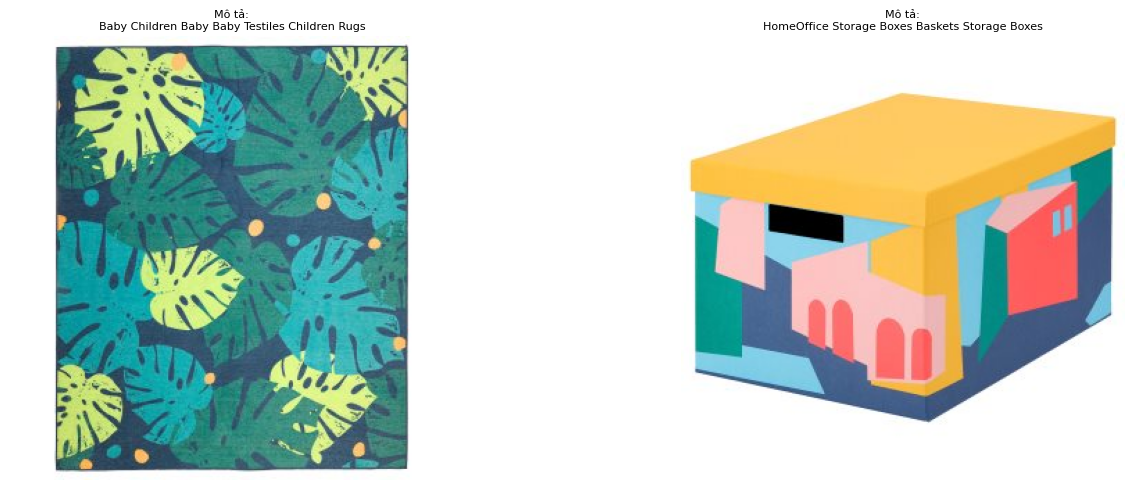


--- Hiển thị 2 ảnh ngẫu nhiên từ Training Data ---


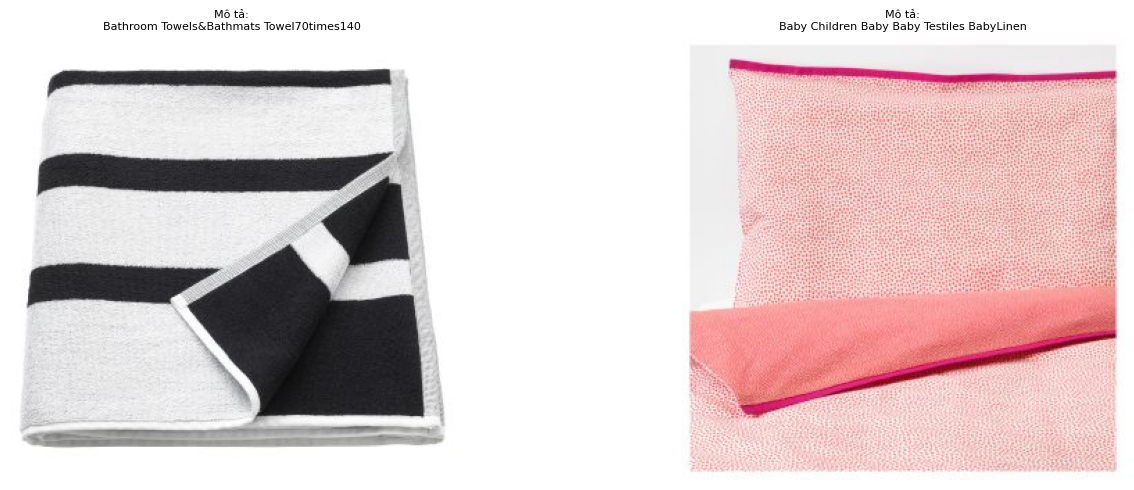

Đang tải dữ liệu từ: ./logs/praxis_clip_finetune/version_0/metrics.csv
Tải dữ liệu thành công! 📊

--- Metric theo Epoch (Đã làm sạch) ---
       train_loss_epoch
epoch                  
0              3.362801
1              2.934040
2              2.632734
3              2.382558
4              2.153428
5              2.002319
6              1.827547
7              1.703786
8              1.576376
9              1.491159

*** PHÂN TÍCH ***
Train Loss cuối cùng: 1.4912
